# Quora Insincere Questions Classification: 2

### Loading Libraries

In [0]:
!pip install regex eli5 emoji

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import os
import re
import csv
import string
import emoji
import regex
import eli5
import pickle
import gensim
import spacy
import gc
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from scipy.sparse import hstack
from IPython.display import Image
from prettytable import PrettyTable

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams

from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.calibration import CalibratedClassifierCV

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

### Loading data

In [4]:
path = '' #'../input/'

df_train = pd.read_csv(path+'train.csv')
df_test = pd.read_csv(path+'test.csv')

print("Number of data points in training data:", df_train.shape[0])
print("Number of data points in test data:", df_test.shape[0])

Number of data points in training data: 1306122
Number of data points in test data: 375806


In [0]:
df_train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


### Data Preprocessing and cleaning

- Replacing math equations and url's with common abbrevation.
- Cleaning contractions.
- Spell Correction.
- Removing punctuations.
- Removing Stopwords.
- Using WordNet Lemmatizer

In [0]:
# Replacing math equations and url addresses with tags.
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

In [0]:
# clean_punct
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
    return x

In [0]:
# correct_mispell
# https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

In [0]:
# remove stopwords
def remove_stopwords(x):
  x = [word for word in x.split() if word not in STOPWORDS]
  x = ' '.join(x)

  return x

In [0]:
# clean word contractions
## https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [0]:
# word lemmatizing

lemmatizer = WordNetLemmatizer()
def lemma_text(x):
  x = x.split()
  x = [lemmatizer.lemmatize(word) for word in x]
  x = ' '.join(x)

  return x

In [0]:
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = correct_mispell(x)
  x = remove_stopwords(x)
  x = clean_contractions(x)
  x = lemma_text(x)
  return x

In [12]:
# preprocessing given train and test data
df_train['preprocessed_question_text'] = df_train['question_text'].progress_map(lambda x: data_cleaning(x))
df_test['preprocessed_question_text'] = df_test['question_text'].progress_map(lambda x: data_cleaning(x))

### Basic Feature Extraction

In [13]:
# Number of words
df_train['num_words'] = df_train['question_text'].apply(lambda x: len(str(x).split()))
df_test['num_words'] = df_test['question_text'].apply(lambda x: len(str(x).split()))

# Number of capital_letters
df_train['num_capital_let'] = df_train['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
df_test['num_capital_let'] = df_test['question_text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))

# Number of unique words
df_train['num_unique_words'] = df_train['question_text'].apply(lambda x: len(set(str(x).split())))
df_test['num_unique_words'] = df_test['question_text'].apply(lambda x: len(set(str(x).split())))

# Number of characters
df_train['num_char'] = df_train['question_text'].apply(lambda x: len(str(x)))
df_test['num_char'] = df_test['question_text'].apply(lambda x: len(str(x)))

# Number of stopwords
df_train['num_stopwords'] = df_train['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
df_test['num_stopwords'] = df_test['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

df_train.head()

,qid,question_text,target,preprocessed_question_text,num_words,num_capital_let,num_unique_words,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How Quebec nationalist see province nation 1960s?,13,2,13,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,Do adopted dog encourage people adopt shop?,16,1,15,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why velocity affect time? Does velocity affect...,10,2,8,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,How Otto von Guericke used Magdeburg hemispheres?,9,4,9,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,Can I convert montra helicon D mountain bike c...,15,3,15,77,7


### Train, Test & Val split

In [14]:
y = df_train['target'].values
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.2, random_state=2019)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2019)

print('X_train: ', X_train.shape, y_train.shape)
print('X_test: ',X_test.shape, y_test.shape)
print('X_val: ',X_val.shape, y_val.shape)

X_train:  (940407, 9) (940407,)
X_test:  (261225, 9) (261225,)
X_val:  (104490, 9) (104490,)


In [0]:
# check for percentage of class disb in train test split.

def plot_class_disb(class_disb, data, disb_name):
  class_disb.plot(kind="bar")
  plt.xlabel('class')
  plt.ylabel('Datapoints per class')
  plt.title(f'Distribution of yi in {disb_name}')
  plt.grid(True)
  
  sorted_yi = np.argsort(-class_disb.values)
  print(disb_name,':')
  for i in sorted_yi:
    print('Number of data points in class', i, ':', class_disb.values[i], '(', np.round((class_disb.values[i]/data.shape[0]*100), 3), '%)')
  
  print('-'*50)

TRAIN :
Number of data points in class 1 : 882455 ( 93.838 %)
Number of data points in class 0 : 57952 ( 6.162 %)
--------------------------------------------------
TEST :
Number of data points in class 1 : 244934 ( 93.764 %)
Number of data points in class 0 : 16291 ( 6.236 %)
--------------------------------------------------
VAILIDATION :
Number of data points in class 1 : 97923 ( 93.715 %)
Number of data points in class 0 : 6567 ( 6.285 %)
--------------------------------------------------


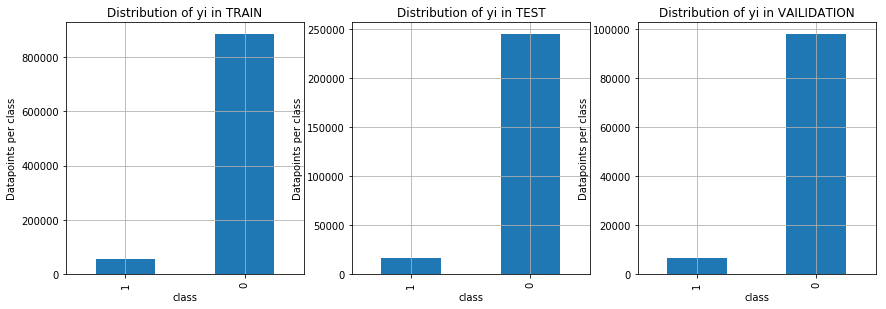

In [0]:
# distribution of yi in train, test and val

plt.subplot(1, 3, 1)
plot_class_disb(
  X_train['target'].value_counts().sort_values(),
  X_train,
  'TRAIN')
         
plt.subplot(1, 3, 2)
plot_class_disb(
  X_test['target'].value_counts().sort_values(),
  X_test,
  'TEST')

plt.subplot(1, 3, 3)
plot_class_disb(
  X_val['target'].value_counts().sort_values(),
  X_val,
  'VAILIDATION')
plt.subplots_adjust(right=2.0)
plt.subplots_adjust(top=1)
plt.show()

### Baseline Model(LR) with basic extracted features

In [15]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))
tfidf.fit_transform(list(df_train['preprocessed_question_text'].values) + list(df_test['preprocessed_question_text'].values))

X_train_ques = tfidf.transform(X_train['preprocessed_question_text'].values)
X_test_ques = tfidf.transform(X_test['preprocessed_question_text'].values)
X_val_ques = tfidf.transform(X_val['preprocessed_question_text'].values)

print(X_train_ques.shape)
print(X_test_ques.shape)
print(X_val_ques.shape)

(940407, 10132167)
(261225, 10132167)
(104490, 10132167)


In [0]:
# Standardize stats features
from sklearn.preprocessing import StandardScaler

# number of words
num_words =  StandardScaler()
X_train_num_words = num_words.fit_transform(X_train['num_words'].values.reshape(-1, 1))
X_test_num_words = num_words.transform(X_test['num_words'].values.reshape(-1, 1))
X_val_num_words = num_words.transform(X_val['num_words'].values.reshape(-1, 1))

# number of unique words
num_unique_words =  StandardScaler()
X_train_num_unique_words = num_unique_words.fit_transform(X_train['num_unique_words'].values.reshape(-1, 1))
X_test_num_unique_words = num_unique_words.transform(X_test['num_unique_words'].values.reshape(-1, 1))
X_val_num_unique_words = num_unique_words.transform(X_val['num_unique_words'].values.reshape(-1, 1))

# number of char
num_char =  StandardScaler()
X_train_num_char = num_char.fit_transform(X_train['num_char'].values.reshape(-1, 1))
X_test_num_char = num_char.transform(X_test['num_char'].values.reshape(-1, 1))
X_val_num_char = num_char.transform(X_val['num_char'].values.reshape(-1, 1))

# number of stopwords
num_stopwords =  StandardScaler()
X_train_num_stopwords = num_stopwords.fit_transform(X_train['num_stopwords'].values.reshape(-1, 1))
X_test_num_stopwords = num_stopwords.transform(X_test['num_stopwords'].values.reshape(-1, 1))
X_val_num_stopwords = num_stopwords.transform(X_val['num_stopwords'].values.reshape(-1, 1))

In [17]:
# Stacking features 

X_tr = hstack((
    X_train_ques,
    X_train_num_words,
    X_train_num_unique_words,
    X_train_num_char,
    X_train_num_stopwords
))

X_te = hstack((
    X_test_ques,
    X_test_num_words,
    X_test_num_unique_words,
    X_test_num_char,
    X_test_num_stopwords
))

X_cv = hstack((
    X_val_ques,
    X_val_num_words,
    X_val_num_unique_words,
    X_val_num_char,
    X_val_num_stopwords
))

print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print(X_cv.shape, y_val.shape)

(940407, 10132171) (940407,)
(261225, 10132171) (261225,)
(104490, 10132171) (104490,)


In [0]:
parmas = {'C': [0.001, 0.001, 0.1, 1, 10]}

gridsearch = GridSearchCV(LogisticRegression(), parmas, scoring='f1', n_jobs=-1, verbose=1)
gridsearch.fit(X_tr, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 11.9min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.001, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [46]:
gridsearch.best_params_

{'C': 1}


In [38]:
clf = LogisticRegression(C=1)
clf.fit(X_tr, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [39]:
y_pred_val = clf.predict_proba(X_cv)[:,1]

for t in np.arange(0.1, 0.201, 0.01):
  t = np.round(t, 2)
  print('F1 score at threshold {0} is {1}'.format(t, f1_score(y_val, (y_pred_val>t).astype('int'))))

F1 score at threshold 0.1 is 0.5440040650406504
F1 score at threshold 0.11 is 0.5573491023387139
F1 score at threshold 0.12 is 0.5654008438818565
F1 score at threshold 0.13 is 0.5732410611303345
F1 score at threshold 0.14 is 0.5804525643321989
F1 score at threshold 0.15 is 0.5851247837904622
F1 score at threshold 0.16 is 0.5868735690663953
F1 score at threshold 0.17 is 0.5878966306836768
F1 score at threshold 0.18 is 0.5883538182550877
F1 score at threshold 0.19 is 0.5885348565136604
F1 score at threshold 0.2 is 0.5849056603773586


In [51]:
t = 0.17
y_pred_test = clf.predict_proba(X_te)[:,1]
print('F1-Score: ', round(f1_score(y_test, (y_pred_test>t)), 5))

F1-Score:  0.5854


In [0]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion Matrix')
  plt.show()
  
  print(f"Correctly classified sincere questions: {round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}%")
  print(f"Correctly classified insincere questions: {round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}%")

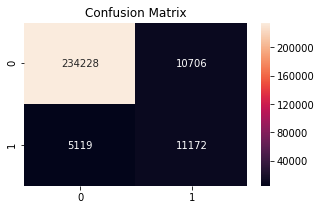

Correctly classified sincere questions: 95.63%
Correctly classified insincere questions: 68.58%


In [52]:
plot_confusion_matrix(y_test, (y_pred_test>t))

In [53]:
print(classification_report(y_test, (y_pred_test>t)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    244934
           1       0.51      0.69      0.59     16291

    accuracy                           0.94    261225
   macro avg       0.74      0.82      0.78    261225
weighted avg       0.95      0.94      0.94    261225



In [0]:
eli5.show_weights(clf, vec=tfidf, top=50, feature_filter=lambda x:x != '<BIAS>')

Weight?,Feature
+21.485,castrated
+17.612,castrate
+17.499,muslims
+17.479,democrats
+17.240,liberals
+16.378,indians
+15.870,castration
+14.737,women
+14.498,americans
+14.409,feminists


In [0]:
def display_incorrect_predictions(data, pred):
  """
  Displays text for both correct|incorrect pred for classes(0, 1)
  """
  
  df_classified = data.copy()
  df_classified['pred'] = (pred>t)
  
  print('\033[1m'+'Sample Class Prediction Anaylsis')
  print('')
  
  print('\033[1m'+'Sincere question:\033[34m Correct prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == False) & (df_classified['target'] ==0) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  print('\033[1m'+'Sincere question:\033[31m Incorrect prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == True) & (df_classified['target'] ==0) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  
  print('-'*50)
  
  print('\033[1m'+'Insincere question :\033[34m Correct prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == True) & (df_classified['target'] ==1) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  print('\033[1m'+'Insincere question:\033[31m Incorrect Prediction')
  print('\033[0m')
  print(data[(df_classified['pred'] == False) & (df_classified['target'] ==1) & (df_classified['num_words'] <15)]['question_text'].head(5).values)
  

In [48]:
display_incorrect_predictions(X_test, (y_pred_test>t))

Sample Class Prediction Anaylsis

Sincere question: Correct prediction

['Why were kyber crystals used for the Death Stars?'
 'Which country would have the most benefits for a child to be born in?'
 'What can I read to learn methodology?'
 'How do I avoid getting that spinning blue circle pointer thingy in Windows 10?'
 'Why an object is subjected to weightlessness during a free-fall?']
Sincere question: Incorrect prediction

['Why did Hitler executed Jews with gas, ovens, shots, etc if they could work?'
 'Why is a dick so long?'
 'How should liberals respond to lies being told about them?'
 'How do I become fearless against people who are rude to me?'
 'Who thinks they can trump the Trump?']
--------------------------------------------------
Insincere question : Correct prediction

['Had Tywin Lannister ever been castrated?'
 'Why do Israeli Muslims hate Israel and Jewish?'
 'Are Indians planning to genocide Nepali-speaking people in India occupied Gorkhaland?'
 'Have you ever had sex